In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from PIL import Image
import random
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import re
import imageio
import pandas as pd
import numpy as np
import os
import glob
import random
from PIL import Image
import shutil

ia.seed(1)
sns.set_theme(style="whitegrid")
%matplotlib inline

In [28]:
csv_path = "concatenate.csv"
image_file_dir = "images"
df = pd.read_csv("concatenate.csv")
df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,100.jpg,213.0,237.0,reliance,25,65,71,116
1,101.jpg,282.0,178.0,reliance,103,14,129,45
2,102.jpg,301.0,167.0,reliance,1,58,75,130
3,103.jpg,260.0,194.0,reliance,92,7,113,24
4,104.jpg,299.0,168.0,reliance,104,67,127,88
...,...,...,...,...,...,...,...,...
1339,882748860.jpg,500.0,298.0,Nbc,123,23,356,249
1340,89201664.jpg,500.0,333.0,McDonalds,10,2,492,318
1341,96668817.jpg,88.0,35.0,Puma,36,2,86,28
1342,98498585.jpg,500.0,375.0,Porsche,133,72,382,322


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1344 entries, 0 to 1343
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1344 non-null   object 
 1   width     1344 non-null   float64
 2   height    1344 non-null   float64
 3   class     1344 non-null   object 
 4   xmin      1344 non-null   int64  
 5   ymin      1344 non-null   int64  
 6   xmax      1344 non-null   int64  
 7   ymax      1344 non-null   int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 84.1+ KB


### See The class distribution

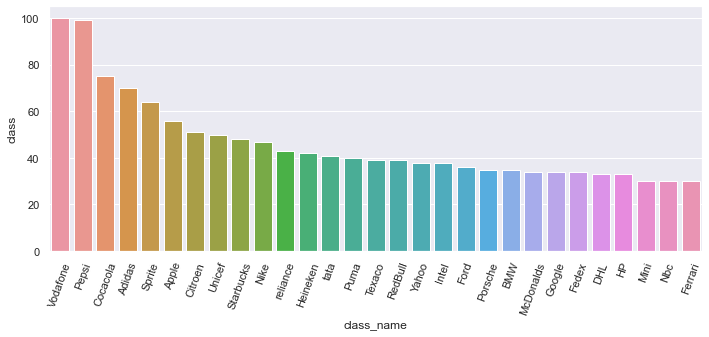

In [11]:
sns.set(rc={'figure.figsize':(11.7,4.5)})
df = pd.DataFrame(pd.value_counts(df['class']))
df['class_name'] = df.index
sns.barplot(x="class_name",y='class',data=df)
plt.xticks(rotation=70)
plt.show()

#### See which image size less than 100

In [12]:
def find_img_less_height():
    df = pd.read_csv(csv_path)
    grou = df.groupby('filename')
    for img_ in glob.glob(f"{image_file_dir}/*.jpg"):
        img_name = os.path.basename(img_)
        group_df = grou.get_group(img_name)
        if  group_df['width'].unique()[0] < 100 and group_df['height'].unique()[0] < 100:
            print(img_name)
    

In [13]:
find_img_less_height()

1263617360.jpg
2090094285.jpg
2317967173.jpg
2364685038.jpg
40394187.jpg
4177800765.jpg
96668817.jpg


### Visualization some random images

In [14]:
def see_random_images_bounding(path,csv_path):
    
    rand_img_basename = random.choice([os.path.basename(im) for im in glob.glob(f"{path}/*.jpg")])
    df = pd.read_csv(csv_path)
    
    grouped = df.groupby('filename')

    ran_img_df = grouped.get_group(rand_img_basename).reset_index()
#     print(ran_img_df)
    ran_img_df = ran_img_df.drop('index',axis=1)
    bbs_df = ran_img_df[ran_img_df.columns[4:]]
    print(ran_img_df['class'])
    
    img = imageio.imread(os.path.join(path,rand_img_basename))
    
    bbs = BoundingBoxesOnImage.from_xyxy_array(bbs_df.values,shape=img.shape)
    ia.imshow(bbs.draw_on_image(img,size=3))

0    Citroen
Name: class, dtype: object


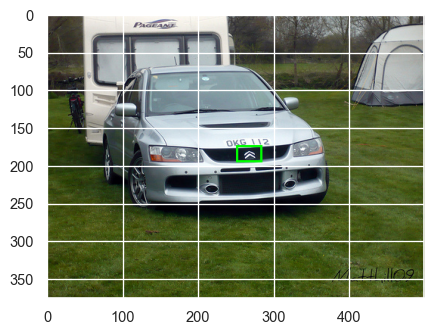

In [15]:
see_random_images_bounding(image_file_dir,csv_path)

0    Nike
1    Nike
2    Nike
Name: class, dtype: object


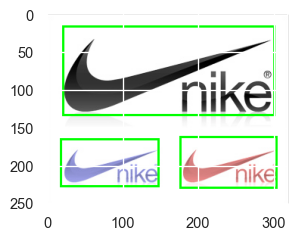

In [16]:
see_random_images_bounding(image_file_dir,csv_path)

### image augmentation  pipline

In [17]:
seq_pipline = iaa.Sequential([
        iaa.OneOf([
        iaa.Flipud(1)
        ,iaa.Rot90([1,3])
        
    ])

    ,iaa.SomeOf((2)
                ,[
         iaa.ChangeColorTemperature((4100, 10000))
        , iaa.AdditiveGaussianNoise(scale=(0, 0.2*255))
        ,iaa.GammaContrast((0.5, 2.0), per_channel=True)
    
    ])
])

In [18]:
def get_read_images(full_image_files_path):
    for image in glob.glob(f"{full_image_files_path}/*.jpg"):
        yield os.path.basename(image),imageio.imread(image)
        
def bbs_array_to_df(bbs_aug):
    bbs = bbs_aug.to_xyxy_array()
    bbs_df = pd.DataFrame(bbs,columns=['xmin', 'ymin', 'xmax', 'ymax'])
    return bbs_df

In [20]:
%%time
how_many_time_auguments_per_images = 4

images_files_train = image_file_dir
label_df = pd.read_csv(csv_path)
grouped = label_df.groupby('filename')
aug_file = 'aug'
os.makedirs(aug_file,exist_ok=True)

aug_image_df = pd.DataFrame(columns=label_df.columns)

total_img = label_df['filename'].unique().size

name_image_dont_aug = []

for name,img in get_read_images(images_files_train):

    for epo in range(how_many_time_auguments_per_images):

        group_df = grouped.get_group(name).reset_index()
        group_df = group_df.drop(['index'],axis=1)

        bbs_df = group_df[group_df.columns[4:]]
        bbs = BoundingBoxesOnImage.from_xyxy_array(bbs_df.values,shape=img.shape)

        image_aug,bbs_aug = seq_pipline(image=img, bounding_boxes=bbs)

        bbs_aug = bbs_aug.remove_out_of_image().clip_out_of_image()

        if re.findall("Image...",str(bbs_aug)) == ['Image([]']:
            name_image_dont_aug.append(name)
            print(name)
            pass

        else:
#             print(os.path.join(aug_file,f"aug_{epo}_{name}"))
            imageio.imwrite(os.path.join(aug_file,f"aug_{epo}_{name}"),image_aug)
#             print("noo")
            new_df = group_df[group_df.columns[:4]]

            for index,_ in new_df.iterrows():
                new_df.loc[index,'height'] = image_aug.shape[0]
                new_df.loc[index,'width'] = image_aug.shape[1]
                new_df.loc[index,'filename'] = f"aug_{epo}_{name}"

            bbs_df = bbs_array_to_df(bbs_aug)

            aug_df = pd.concat([new_df,bbs_df],axis=1) #columns added
            aug_image_df = pd.concat([aug_image_df,aug_df])



aug_image_df = aug_image_df.reset_index()
aug_image_df = aug_image_df.drop('index',axis=1)
print(" "*2,"-"*5,f"Total images was {how_many_time_auguments_per_images*total_img+how_many_time_auguments_per_images}","-"*5,end='\n\n')
print(">"*15," Game On ","<"*15)


   ----- Total images was 3516 -----

>>>>>>>>>>>>>>>  Game On  <<<<<<<<<<<<<<<
Wall time: 5min 26s


In [21]:
aug_csv = aug_image_df.copy()
aug_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  5376 non-null   object 
 1   width     5376 non-null   float64
 2   height    5376 non-null   float64
 3   class     5376 non-null   object 
 4   xmin      5376 non-null   float32
 5   ymin      5376 non-null   float32
 6   xmax      5376 non-null   float32
 7   ymax      5376 non-null   float32
dtypes: float32(4), float64(2), object(2)
memory usage: 252.1+ KB


In [22]:
aug_csv.tail(10)

,filename,width,height,class,xmin,ymin,xmax,ymax
5366,aug_2_96668817.jpg,88.0,35.0,Puma,36.000000,7.000000,86.000000,33.000000
5367,aug_3_96668817.jpg,88.0,35.0,Puma,36.000000,7.000000,86.000000,33.000000
5368,aug_0_98498585.jpg,500.0,375.0,Porsche,133.000000,53.000000,382.000000,303.000000
5369,aug_1_98498585.jpg,500.0,375.0,Porsche,133.000000,53.000000,382.000000,303.000000
5370,aug_2_98498585.jpg,500.0,375.0,Porsche,133.000000,53.000000,382.000000,303.000000
5371,aug_3_98498585.jpg,500.0,375.0,Porsche,133.000000,53.000000,382.000000,303.000000
5372,aug_0_99816106.jpg,500.0,333.0,Puma,52.552551,73.260002,369.369354,223.776001
5373,aug_1_99816106.jpg,500.0,333.0,Puma,52.552551,73.260002,369.369354,223.776001
5374,aug_2_99816106.jpg,500.0,333.0,Puma,52.552551,73.260002,369.369354,223.776001
5375,aug_3_99816106.jpg,500.0,333.0,Puma,164.000000,87.000000,390.000000,298.000000


#### convert columns values form float to int

In [23]:

for col in aug_csv.columns[1:]:
    if col != 'class':
        aug_csv[col] = round(aug_csv[col])

In [24]:
aug_csv.head(10)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,aug_0_100.jpg,213.0,237.0,reliance,25.0,121.0,71.0,172.0
1,aug_1_100.jpg,213.0,237.0,reliance,109.0,28.0,155.0,79.0
2,aug_2_100.jpg,213.0,237.0,reliance,109.0,28.0,155.0,79.0
3,aug_3_100.jpg,213.0,237.0,reliance,25.0,121.0,71.0,172.0
4,aug_0_101.jpg,282.0,178.0,reliance,211.0,65.0,260.0,81.0
5,aug_1_101.jpg,282.0,178.0,reliance,103.0,133.0,129.0,164.0
6,aug_2_101.jpg,282.0,178.0,reliance,211.0,65.0,260.0,81.0
7,aug_3_101.jpg,282.0,178.0,reliance,103.0,133.0,129.0,164.0
8,aug_0_102.jpg,301.0,167.0,reliance,67.0,1.0,196.0,42.0
9,aug_1_102.jpg,301.0,167.0,reliance,1.0,37.0,75.0,109.0


### cleaning aug datasets

In [25]:
aug_img_path = "aug"
grouped = aug_csv.groupby("filename")
for img_ in glob.glob(f"{aug_img_path}/*.jpg"):
    img_name = os.path.basename(img_)
    group_df = grouped.get_group(img_name)
    
    for index,_ in group_df.iterrows():
        xmin = int(group_df.loc[index,'xmin'])
        xmax = int(group_df.loc[index,'xmax'])
        ymax = int(group_df.loc[index,'ymax'])
        ymin = int(group_df.loc[index,'ymin'])
        if xmax > xmin : pass
        else:print(img_name,"x axis")
        if ymax > ymin :pass
        else: print(img_name,"y axis")

### I have not found any miss leading augmenation data

### concant csv

In [29]:
df = pd.read_csv("concatenate.csv")
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,100.jpg,213.0,237.0,reliance,25,65,71,116
1,101.jpg,282.0,178.0,reliance,103,14,129,45
2,102.jpg,301.0,167.0,reliance,1,58,75,130
3,103.jpg,260.0,194.0,reliance,92,7,113,24
4,104.jpg,299.0,168.0,reliance,104,67,127,88


In [30]:
aug_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,aug_0_100.jpg,213.0,237.0,reliance,25.0,121.0,71.0,172.0
1,aug_1_100.jpg,213.0,237.0,reliance,109.0,28.0,155.0,79.0
2,aug_2_100.jpg,213.0,237.0,reliance,109.0,28.0,155.0,79.0
3,aug_3_100.jpg,213.0,237.0,reliance,25.0,121.0,71.0,172.0
4,aug_0_101.jpg,282.0,178.0,reliance,211.0,65.0,260.0,81.0


In [31]:
df_concat = pd.concat([df,aug_csv],axis=0)
df_concat = df_concat.reset_index(drop=True)
df_concat

,filename,width,height,class,xmin,ymin,xmax,ymax
0,100.jpg,213.0,237.0,reliance,25.0,65.0,71.0,116.0
1,101.jpg,282.0,178.0,reliance,103.0,14.0,129.0,45.0
2,102.jpg,301.0,167.0,reliance,1.0,58.0,75.0,130.0
3,103.jpg,260.0,194.0,reliance,92.0,7.0,113.0,24.0
4,104.jpg,299.0,168.0,reliance,104.0,67.0,127.0,88.0
...,...,...,...,...,...,...,...,...
6715,aug_3_98498585.jpg,500.0,375.0,Porsche,133.0,53.0,382.0,303.0
6716,aug_0_99816106.jpg,500.0,333.0,Puma,53.0,73.0,369.0,224.0
6717,aug_1_99816106.jpg,500.0,333.0,Puma,53.0,73.0,369.0,224.0
6718,aug_2_99816106.jpg,500.0,333.0,Puma,53.0,73.0,369.0,224.0


In [32]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6720 entries, 0 to 6719
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  6720 non-null   object 
 1   width     6720 non-null   float64
 2   height    6720 non-null   float64
 3   class     6720 non-null   object 
 4   xmin      6720 non-null   float64
 5   ymin      6720 non-null   float64
 6   xmax      6720 non-null   float64
 7   ymax      6720 non-null   float64
dtypes: float64(6), object(2)
memory usage: 420.1+ KB


In [33]:
df_concat.to_csv("images.csv",index=None)

### Copy aug dir  in  images dir

In [34]:
%%time
for img_ in glob.glob(f"{aug_file}/*jpg"):
    shutil.copy(img_,os.path.join(image_file_dir,os.path.basename(img_)))
print("Sucefully copy files")

Sucefully copy files
Wall time: 35.2 s


### Visualization  augmentation random images

0    Porsche
Name: class, dtype: object


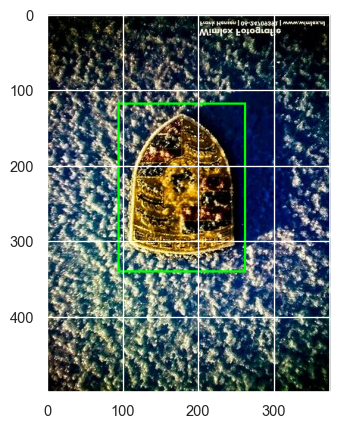

In [37]:
path_df = "images.csv"
path_image = "images"
see_random_images_bounding(path_image,path_df)

0    McDonalds
Name: class, dtype: object


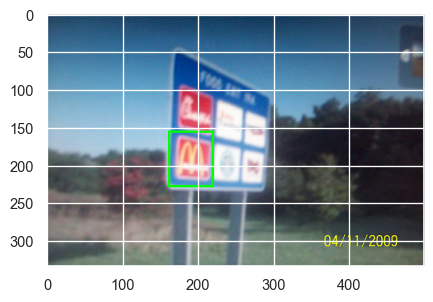

In [97]:
see_random_images_bounding(path_image,path_df)

0    reliance
Name: class, dtype: object


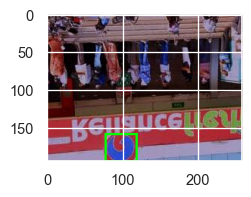

In [99]:
see_random_images_bounding(path_image,path_df)